In [36]:
import torch
import os, sys
import tiktoken

project_root = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir)
)

stage1_root = os.path.join(project_root, "stage1")
sys.path.insert(0, stage1_root)

# now 'src' is a top-level package
from src.gpt2small import GPTModel, GPTConfig124, generate_text


In [37]:
cfg_pt = GPTConfig124(vocab_size=50257, context_length=256, emb_dim=768,
                   n_heads=12, n_layers=12, dropout=0.1, qkv_bias=False)
torch.manual_seed(123)
model = GPTModel(cfg_pt)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [38]:
def text_to_token_ids(text, tokenizer, allowed_special):
    """
    tensor.unsqueeze(dim) inserts a new axis (of size 1) at index dim.
    x = torch.tensor([10, 20, 30])       shape: [3]
    x0 = x.unsqueeze(0)                 shape: [1,3]
    x1 = x.unsqueeze(1)                 shape: [3,1]
    """
    allowed_special = allowed_special or ('<|endoftext|>')
    token_list = tokenizer.encode(text, allowed_special=set(allowed_special))
    ids = torch.tensor(token_list).unsqueeze(0)
    #unsqueeze turns a 1D sequence of token IDs into a 2D batch of size 1.
    #almost all pytorch nn.Modules (embeddings, transformers, etc.)
    # expect inputs of shape (batch_size, seq_len, ...)
    # even f we only have one example, we need to present it as a batch of size 1.
    return ids

def token_ids_to_text(token_ids, tokenizer):
    """
    tensor.squeeze(dim: optional) removes the axis at index dim if its size is 1.
    y = torch.zeros(1, 5, 1)         shape: [1,5,1]
    y0 = y.squeeze(0)               shape: [5,1]
    y1 = y.squeeze(2)               shape: [1,5]
    y2 = y.squeeze()               shape: [5] (all dims 1 are removed)
    """
    flat = token_ids.squeeze(0)
    #squeeze(0) just undoes the batch dimension we previously added,
    # giving back the raw token sequence.
    return tokenizer.decode(flat.tolist())

st_context = "A man told me"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text(
    model = model,
    idx = text_to_token_ids(st_context, tokenizer, allowed_special=None),
    max_new_tokens = 10,
    context_size = cfg_pt.context_length
)

print('Output text: ', token_ids_to_text(token_ids, tokenizer))

Output text:  A man told me accumulation thumbnail Flask 406 propensity Hat lush Tulsolk se


### Text Generation Loss

As can be seen from the output above, our model is producing random, non-coherent text. This is because it has not yet undergone training (and because the input size is very limited). Training is done in order to increase the softmax probability of the index positions that correspond to the correct target token position. A non-trained model will simply return the argmax of a rather arbitrary softmax distribution (random vectors) across the vocab size, for each token. The goal with training is then to maximize the chance of selecting the correct token by increasing its selection probability relative to other tokens.

In [39]:
text = """A man told me once that all the bad people
Were needed. Maybe not all, but your fingernails
You need; they are really claws, and we know
Claws. The sharks--what about them?
They make other fish swim faster. The hard-faced men
In black coats who chase you for hours
In dreams--that's the only way to get you
To the shore. Sometimes those hard women
Who abandon you get you to say, "You."
A lazy part of us is like a tumbleweed.
It doesn't move on its own. It takes sometimes
A lot of Depression to get tumbleweeds moving.
Then they blow across three or four States.
This man told me that things work together.
Bad handwriting sometimes leads to new ideas;
And a careless God--who refuses to let you
Eat from the Tree of Knowledge--can lead
To books, and eventually to us. We write
Poems with lies in them, but they help a little."""

tokens = text_to_token_ids(text, tokenizer, allowed_special=None)
print(f'Shape of tokens: {tokens.shape}')
print(f'Tokens:\n {tokens}')

B, T = 2, 4 #(batch_size, seq_len)
data = tokens[0][:8+1]

x = data[:-1].view(B,T) #input tensor
y = data[1:].view(B,T) #target tensor for next token prediction

print(f'Inputs:\n {x}')
print(f'Targets:\n {y}')

with torch.no_grad(): #we are not training yet, just an example
    logits = model(x)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)


Shape of tokens: torch.Size([1, 212])
Tokens:
 tensor([[   32,   582,  1297,   502,  1752,   326,   477,   262,  2089,   661,
           198, 35653,  2622,    13,  6674,   407,   477,    11,   475,   534,
          8038,  1142,  1768,   198,  1639,   761,    26,   484,   389,  1107,
         28421,    11,   290,   356,   760,   198,  2601,  8356,    13,   383,
         27476,   438, 10919,   546,   606,    30,   198,  2990,   787,   584,
          5916,  9422,  5443,    13,   383,  1327,    12, 24903,  1450,   198,
           818,  2042, 30720,   508, 15505,   345,   329,  2250,   198,   818,
         10625,   438,  5562,   338,   262,   691,   835,   284,   651,   345,
           198,  2514,   262, 15191,    13,  8975,   883,  1327,  1466,   198,
          8241,  6871,   345,   651,   345,   284,   910,    11,   366,  1639,
           526,   198,    32, 16931,   636,   286,   514,   318,   588,   257,
         47978, 39054,    13,   198,  1026,  1595,   470,  1445,   319,   663,
     

Note that the dimension of the probability tensor is [2, 4, 50257], the same as the logits output shape of our model (batch_size, seq_len, d_model).

In [40]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[12434],
         [22182],
         [22418],
         [24106]],

        [[ 9099],
         [30130],
         [40937],
         [34965]]])


The output above yields two sets of outputs, one for each batch in the inputs. Each element in each set is the predicted token IDs of the next word, from each word. Perhaps this is better explained visually.

In [41]:
preds = token_ids.squeeze(-1)
batch_size, seq_len = x.shape

for b in range(batch_size):
    for t in range(seq_len):
        inp_id = x[b,t].item()
        pred_id = preds[b,t].item()

        inp_tok = tokenizer.decode([inp_id])
        pred_tok = tokenizer.decode([pred_id])

        print(f"'{inp_tok}' [{inp_id}] ---> '{pred_tok}' [{pred_id}]")

'A' [32] ---> ' Driver' [12434]
' man' [582] ---> 'NP' [22182]
' told' [1297] ---> ' Munich' [22418]
' me' [502] ---> ' accumulation' [24106]
' once' [1752] ---> 'don' [9099]
' that' [326] ---> ' eagerly' [30130]
' all' [477] ---> ' dogma' [40937]
' the' [262] ---> ' ali' [34965]


In [42]:
print(f'Targets batch 1:\n {token_ids_to_text(y[0], tokenizer)}')
print(f'Outputs batch 1:\n {token_ids_to_text(token_ids[0].flatten(), tokenizer)}')
print(f'Targets batch 2: \n {token_ids_to_text(y[1], tokenizer)}')
print(f'Outputs batch 2:\n {token_ids_to_text(token_ids[1].flatten(), tokenizer)}')

Targets batch 1:
  man told me once
Outputs batch 1:
  DriverNP Munich accumulation
Targets batch 2: 
  that all the bad
Outputs batch 2:
 don eagerly dogma ali


As we can see, the model is producing very wrong, random texts that are vastly different from the target. We need to figure out a way to evaluate the performance of the model's generated text numerically through using some sort of loss metric. Using this loss, we can then implement a training function to robustly and iteratively update the model's weights and improve the generated text. But, in a context like language understanding and text generation, how do you build this loss? We want to measure how far, or how different the generated tokens are from the correct targets. But how do we embed this information in a function to optimize? How do you even begin to define inaccuracy or incorrectness in text generation, which might have no objectively correct next word?

In [43]:
y_1 = y[0].unsqueeze(1)
y_2 = y[1].unsqueeze(1)# (T,1)
target_probas_1 = probas[0].gather(dim=1, index=y_1).squeeze(1)
target_probas_2 = probas[1].gather(dim=1, index=y_2).squeeze(1)
print(f'The four target token ID probs for batch 1 are:\n', target_probas_1)
print(f'The four target token ID probs for batch 2 are:\n', target_probas_2)

The four target token ID probs for batch 1 are:
 tensor([7.7823e-06, 1.6688e-05, 1.7775e-05, 1.2489e-05])
The four target token ID probs for batch 2 are:
 tensor([1.1684e-05, 1.5996e-05, 8.7344e-06, 2.2723e-05])


To summarize our process thus far:

1. **Compute the raw mode outputs (logits).** These are the unnormalized scores that the GPT model assigns to every possible next token in its vocabulary. These reflect the model's relative confidence in each token before normalization.
2. **Normalize via softmax to obtain a probability distribution.** We convert the raw scores into a proper probability distribution over all tokens.
3. **Extract the probabilities of true next tokens.** For each position in every sequence of our batch, we index into the softmax output to retrieve the probability assigned to the actual (target) next token. This gives us a measure of how likely the model considers the correct continuation at each step.

Next, we will calculate the loss for the probability scores (one possible method) of our two example sentences by applying the logarithm to the probability scores.

In [44]:
target_probas = torch.cat((target_probas_1, target_probas_2))
log_probs = torch.log(target_probas)
print(f'Log probs:\n {log_probs}')

Log probs:
 tensor([-11.7637, -11.0008, -10.9377, -11.2907, -11.3573, -11.0432, -11.6482,
        -10.6921])


When we take the log of our model's predicted probabilities and use log-probabilities as the basis for our loss, we are constructing the (for relatively experienced readers) familiar negative-log-likelihood (or cross-entropy) objective that underpins many modern language models, and many other families of models as well. If our model assigns prob $p_{\theta}(y_t | x_{\lt t})$ to the correct next token $y_t$ given context $x_{\lt t}$, then the joint likelihood of a full sequence $y_{1:T}$ is the product:

$$
L(\theta) = \prod_{t=1}^{T} p_{\theta}(y_t | x_{\lt t})
$$

and maximizing this product directly is equivalent to maximizing its logarithm (since log is a strictly increasing function:

$$
\text{log}L(\theta) = \sum_{t=1}^{T} \text{log}\space p_{\theta}(y_t | x_{\lt t})
$$

So that minimizing $\mathcal{L}$ is exactly the same as maximizing the original likelihood $L$, we define the loss as the negative of this log-likelihood. It is this loss that we want to bring down to zero:

$$
\mathcal{L} = -\sum_{t=1}^{T} \text{log}\space p_{\theta}(y_t | x_{\lt t})
$$

We then average this quantity over batches and time-steps, but an essential insight remains: working with a sum of the logs of many small numbers is mathematically simpler to differentiate and numerically more stable than working with the product of these many small numbers. From a numerical standpoint, probabilities are bounded between 0 and 1, so when a model makes many predictions in a sequence the product of those probabilities can tend to really small numbers or underflow to zero. Taking the log of each probability allows us to work with numbers whose magnitudes grow linearly rather than exponentially, and floating-point addition is more stable than repeated multiplication of numbers less than one. Additionally, since log turns products into sums:

$$
\log({p_1 \times p_2 \times \dots \times p_T}) = \sum_{t=1}^{T}\log{p_t}
$$

we can compute loss for each time-step independently, aggregating them without the fear of catastrophic underflow. But beyond this stability, the log-loss also has compelling statistical and informational interpretations. In maximum likelihood estimation, one chooses model parameters $\theta$ to make the observed data as probable as possible; equivalently, one minimizes the negative log-likelihood. From an information theory, $-\log p_{\theta}(y)$ measures the 'surprise' of event $y$. When we minimize the expected $-\log p$, we are minimizing the Shannon cross-entropy between the true data distribution and our model's approximation. The cross-entropy is then a measure of the difference between two probability distributions.

On the optimizatin side, using a sum of log-probs yields gradients that emphasize mispredicted or low-probability events. If at time-step $t$ the model assigns probability $p_t$ to the correct token, then the derivative of $-\log p_t$ with respect to the underlying score is $\frac{-1}{p_t}$, so the smaller $p_t$, the larger the gradient magnitude.


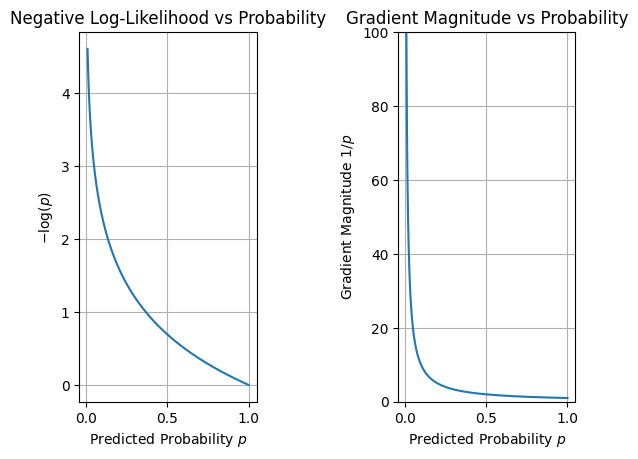

In [45]:
import numpy as np
import matplotlib.pyplot as plt


p = np.linspace(0.01, 1.0, 1000)
# Compute negative log-loss
neg_log = -np.log(p)

figure, axis = plt.subplots(1, 2)
axis[0].plot(p, neg_log)
axis[0].set_title('Negative Log-Likelihood vs Probability')
axis[0].set_xlabel('Predicted Probability $p$')
axis[0].set_ylabel('$-\\log(p)$')
axis[0].grid(True)

#-log(p): d(-log p)/dp = 1/p
grad_mag = 1 / p

axis[1].plot(p, grad_mag)
axis[1].set_title('Gradient Magnitude vs Probability')
axis[1].set_xlabel('Predicted Probability $p$')
axis[1].set_ylabel('Gradient Magnitude $1/p$')
axis[1].set_ylim(0, 100)  # limit y-axis for clarity
axis[1].grid(True)

figure.subplots_adjust(wspace=0.8)
plt.show()


Let's continue with our loss calculation by taking the average of the log probability scores, and then multiplying by -1.

In [46]:
avg_log_probas = torch.mean(log_probs)
print(avg_log_probas)
neg_avg_log_probas = -avg_log_probas
print(neg_avg_log_probas)

tensor(-11.2167)
tensor(11.2167)


In [47]:
logits_flat = logits.flatten(0, 1) #(batch_size, seq_len, d_model) --> (batch_size * seq_len, d_model)
y_flat = y.flatten() #(batch_size, seq_len) --> (batch_size * seq_len)
loss = torch.nn.functional.cross_entropy(logits_flat, y_flat)
print(f'Loss: {loss}')

Loss: 11.216712951660156


> As we can see above, PyTorch's built in `cross_entropy` function applies softmax on raw logits , selects the probabilites corresponding to target IDs for each token, and computes the negative average log probabilities. In other words, it does all the work for us.

#### Perplexity
Perplexity is, at its heart, a re-expression of cross-entropy in the original token domain rather than in log space. It essentially answers the question, *'On average, how many equally likely tokens would the model be as uncertain about as it is in reality?'*. When we train a language model we minimize the average negative log-likelihood per token, which is measures in natural logarithms, or bits (if we use base-2 logs). While this is the correct objective for maximum-likelihood estimation, a loss of, say, 10 natural logarithms per token can feel a bit too abstract. What does '10 units of suprise' mean, exactly? Perplexity is used to bridge that gap by exponentiating the average loss so that our metric lives back in the token domain:

$$
\text{Perplexity} = \text{exp}(\mathcal{L})
$$

If our model has perplexity of 50, we can say that, on average, it is as uncertain as if it had to choose uniformly among 50 tokens. A perfectly certain model (one that assigns a prob. of 1 to the correct next token) would have a cross-entropy loss of 0, and a perplexity of 1, reflecting zero uncertainty, exactly one choice. Exponentiating turns sums of logs (our loss) back into products of probabiliites. If cross-entropy is the arithmetic mean of 'surprise' ($-\log p$), then exponentiating this computes the geometric mean of $\frac{1}{p}$, which quantifies how 'wide' the model's distribution really is. In a way, it is telling us the model's effective vocabulary size given its actual uncertainty, and it therefore directly comparable across different datasets and tokenizations, as long as the vocabulary size is fixed.




In [48]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(74362.9375)


### Training

 To compute the loss on a training and validation set, we will use "Pride and Prejudice" by Jane Austen (1813). The full-book was obtained from [Project Gutenberg](https://www.gutenberg.org/), and then converted to a .txt file via the epub2txt library.
 > Important: *This eBook is for the use of anyone anywhere in the United States and most
other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online
at www.gutenberg.org. If you
are not located in the United States, you will have to check the laws
of the country where you are located before using this eBook.*

In [49]:
pandp = '../../../data/pride_and_prejudice.txt'
with open(pandp, "r", encoding="utf-8") as f:
    text = f.read()

character_num = len(text)
tokens_num = len(tokenizer.encode(text))
print(f'Number of characters in text: {character_num}')
print(f'Number of tokens in text: {tokens_num}')

Number of characters in text: 704415
Number of tokens in text: 177123


Let's split the dataset to create a training set, and a separate validation set. We will then divide the tokenized text into pieces of a pre-defined length (`context_length` parameter). Note that, in practice, it is often beneficial to allow variable-length inputs to make our LLM generalize better across inputs of variable types and lengths.

We will use 85% of the data for training, and the remaining 15% as a validation set.

In [52]:
from src.load_data import create_dataloader

def split_text(text, ratio):
    """split raw text into training/val sets by char index"""
    split_point = int(ratio * len(text))
    train_data, val_data = text[:split_point], text[split_point:]
    return train_data, val_data

def build_loaders(text, cfg, batch_size=4, split_ratio=0.85, seed=123, num_workers=0):
    train_data, val_data = split_text(text, split_ratio)
    torch.manual_seed(seed)

    common_pars = dict(
        batch_size=batch_size,
        max_length=cfg.context_length,
        stride=cfg.context_length,
        num_workers=num_workers
    )

    train_loader = create_dataloader(
        train_data, shuffle=True, drop_last=True, **common_pars
    )
    val_loader = create_dataloader(
        val_data, shuffle=False, drop_last=False, **common_pars
    )
    return train_loader, val_loader

def print_loader_shapes(loaders):
    for name, loader in loaders.items():
        print(f'{name.capitalize()} loader:')
        for i, (x, y) in enumerate(loader, start=1):
            print(f'Batch #{i}: x.shape={x.shape}, y.shape={y.shape}')
        print()

train_loader, val_loader = build_loaders(text, cfg_pt)
print_loader_shapes({'train':train_loader,
                    'validation':val_loader})

Train loader:
Batch #1: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #2: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #3: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #4: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #5: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #6: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #7: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #8: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #9: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #10: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #11: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #12: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #13: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #14: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #15: x.sh

As can be seen in the output above, a 85/15 training/validation split yields 146 training batches, with 4 samples and 256 tokens each. We also have 26 validation batches, also consisting of 4 examples and 256 tokens each. Note also that the input x and target y are of the same shape (since the targets are just the inputs shifted by a single position). Let's now calculate the cross-entropy loss for a given batch.

In [53]:
def calc_loss_cross_entropy(logits, target):
    """
    logits.shape == (batch_size, sequence_length, vocab_size)
    targets.shape == (batch_size, sequence_length)
    """
    flat_logits = logits.flatten(0, 1)
    flat_targets = target.flatten(0)
    return torch.nn.functional.cross_entropy(flat_logits, flat_targets)


def eval_loss(data_loader, model, device, max_batches=None):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if max_batches is not None and i >= max_batches:
                break
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total += calc_loss_cross_entropy(logits, y).item()
            count += 1
    return float('nan') if count == 0 else total / count

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loss = eval_loss(train_loader, model, device)
val_loss = eval_loss(val_loader, model, device)
print(f"Train loss: {train_loss}")
print(f"Valid loss: {val_loss}")

Train loss: 10.972495980458717
Valid loss: 10.97874982540424


In [55]:
print(f'Training perplexity: {torch.exp(torch.tensor(train_loss))}')
print(f'Validation perplexity: {torch.exp(torch.tensor(val_loss))}')

Training perplexity: 58249.8046875
Validation perplexity: 58615.25390625


As shown above, the loss values are very high, reflecting the fact that the model has not been trained. At least we now have a way to measure the quality of the text that is generated, and can now proceed to methodologicaly train the LLM to reduce this loss and improve our model!